## 13장. 합성곱 신경망을 사용한 이미지 분류

### 1. 패션 MNIST 데이터 불러오기

In [1]:
# 텐서플로 라이브러리에서 keras 패키지를 임포트한다.
from tensorflow import keras
from sklearn.model_selection import train_test_split

# 패션 MNIST 데이터를 로드한다.
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

# 넘파이 reshape()를 사용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원을 추가한다.
# 훈련데이터를 0~1 사이의 값으로 정규화한다.
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

# 훈련세트와 검증세트로 분리한다.
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

4431872/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기
**2.1 첫 번째 합성곱 - 풀링층 추가**

In [2]:
# 신경망 모델을 생성한다.
model = keras.Sequential()

In [3]:
# 신경망 모델에 합성곱 층을 추가한다.
# 필터 개수는 32, 커널의 크기는 (3,3), 활성화함수는 렐루 함수, 패딩은 세임 패딩
# 입력 크기는 (28, 28, 1)으로 지정한다.
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same',
                              input_shape=(28, 28, 1)))

In [4]:
# 신경망 모델에 폴링 층을 추가한다.
# 최대 풀링을 사용하며 풀링 크기는 (2, 2)로 지정한다.
model.add(keras.layers.MaxPooling2D(2))

**2.2 두 번째 합성곱-폴링층 추가**

In [5]:
# 신경망 모델에 필터의 개수가 63개인 합성곱 층을 추가한다.
# 필터의 개수는 63, 커널의 크기는 (3,3), 활성화 함수는 렐루함수, 패딩은 세임패딩을 지정한다.
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))

# 신경망 모델에 폴링 층을 추가한다.
# 최대 풀링을 사용하며 풀링 크기는 (2, 2)로 지정한다.
model.add(keras.layers.MaxPooling2D(2))

**2.3 세번째 완전 연결층**

In [6]:
# Flatten 층을 추가한다.
# Flatten 층은 3차원 특성맵을 일렬로 펼친다.
model.add(keras.layers.Flatten())

# 학습, 예측, 평가 계산을 위한 밀집층(은닉층)을 추가하낟.
# 100개의 뉴런을 사용하고 활성화 함수는 렐루함수를 사용한다.
model.add(keras.layers.Dense(100, activation='relu'))

# 과대적합을 막아 성능을 개선하기 위한 드롭아웃 층을 추가한다.
model.add(keras.layers.Dropout(0.4))

# 클래스 분류 확률 계산을 위한 밀집층(출력층)을 추가하낟.
# 10개의 뉴련을 사용하고 활성화 함수는 소프트맥스 함수를 사용한다.
model.add(keras.layers.Dense(10, activation='softmax'))

In [7]:
# summary()으로 신경망 모델의 정보를 출력한다.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output sealed.Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)         

**2.4 신경망 구조를 그림을 출력**

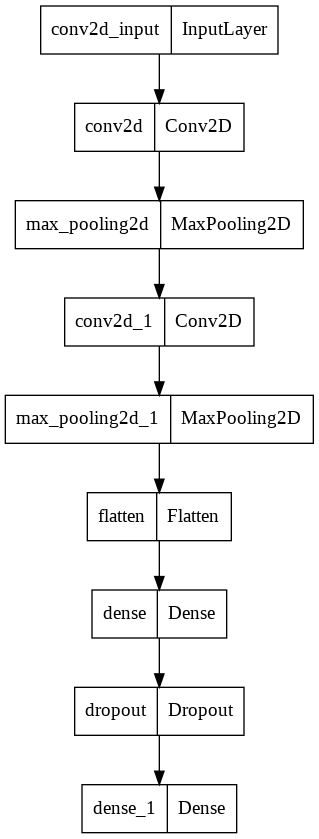

In [8]:
# plot_model()으로 model 신경망 구조를 그림으로 출력한다.
keras.utils.plot_model(model)

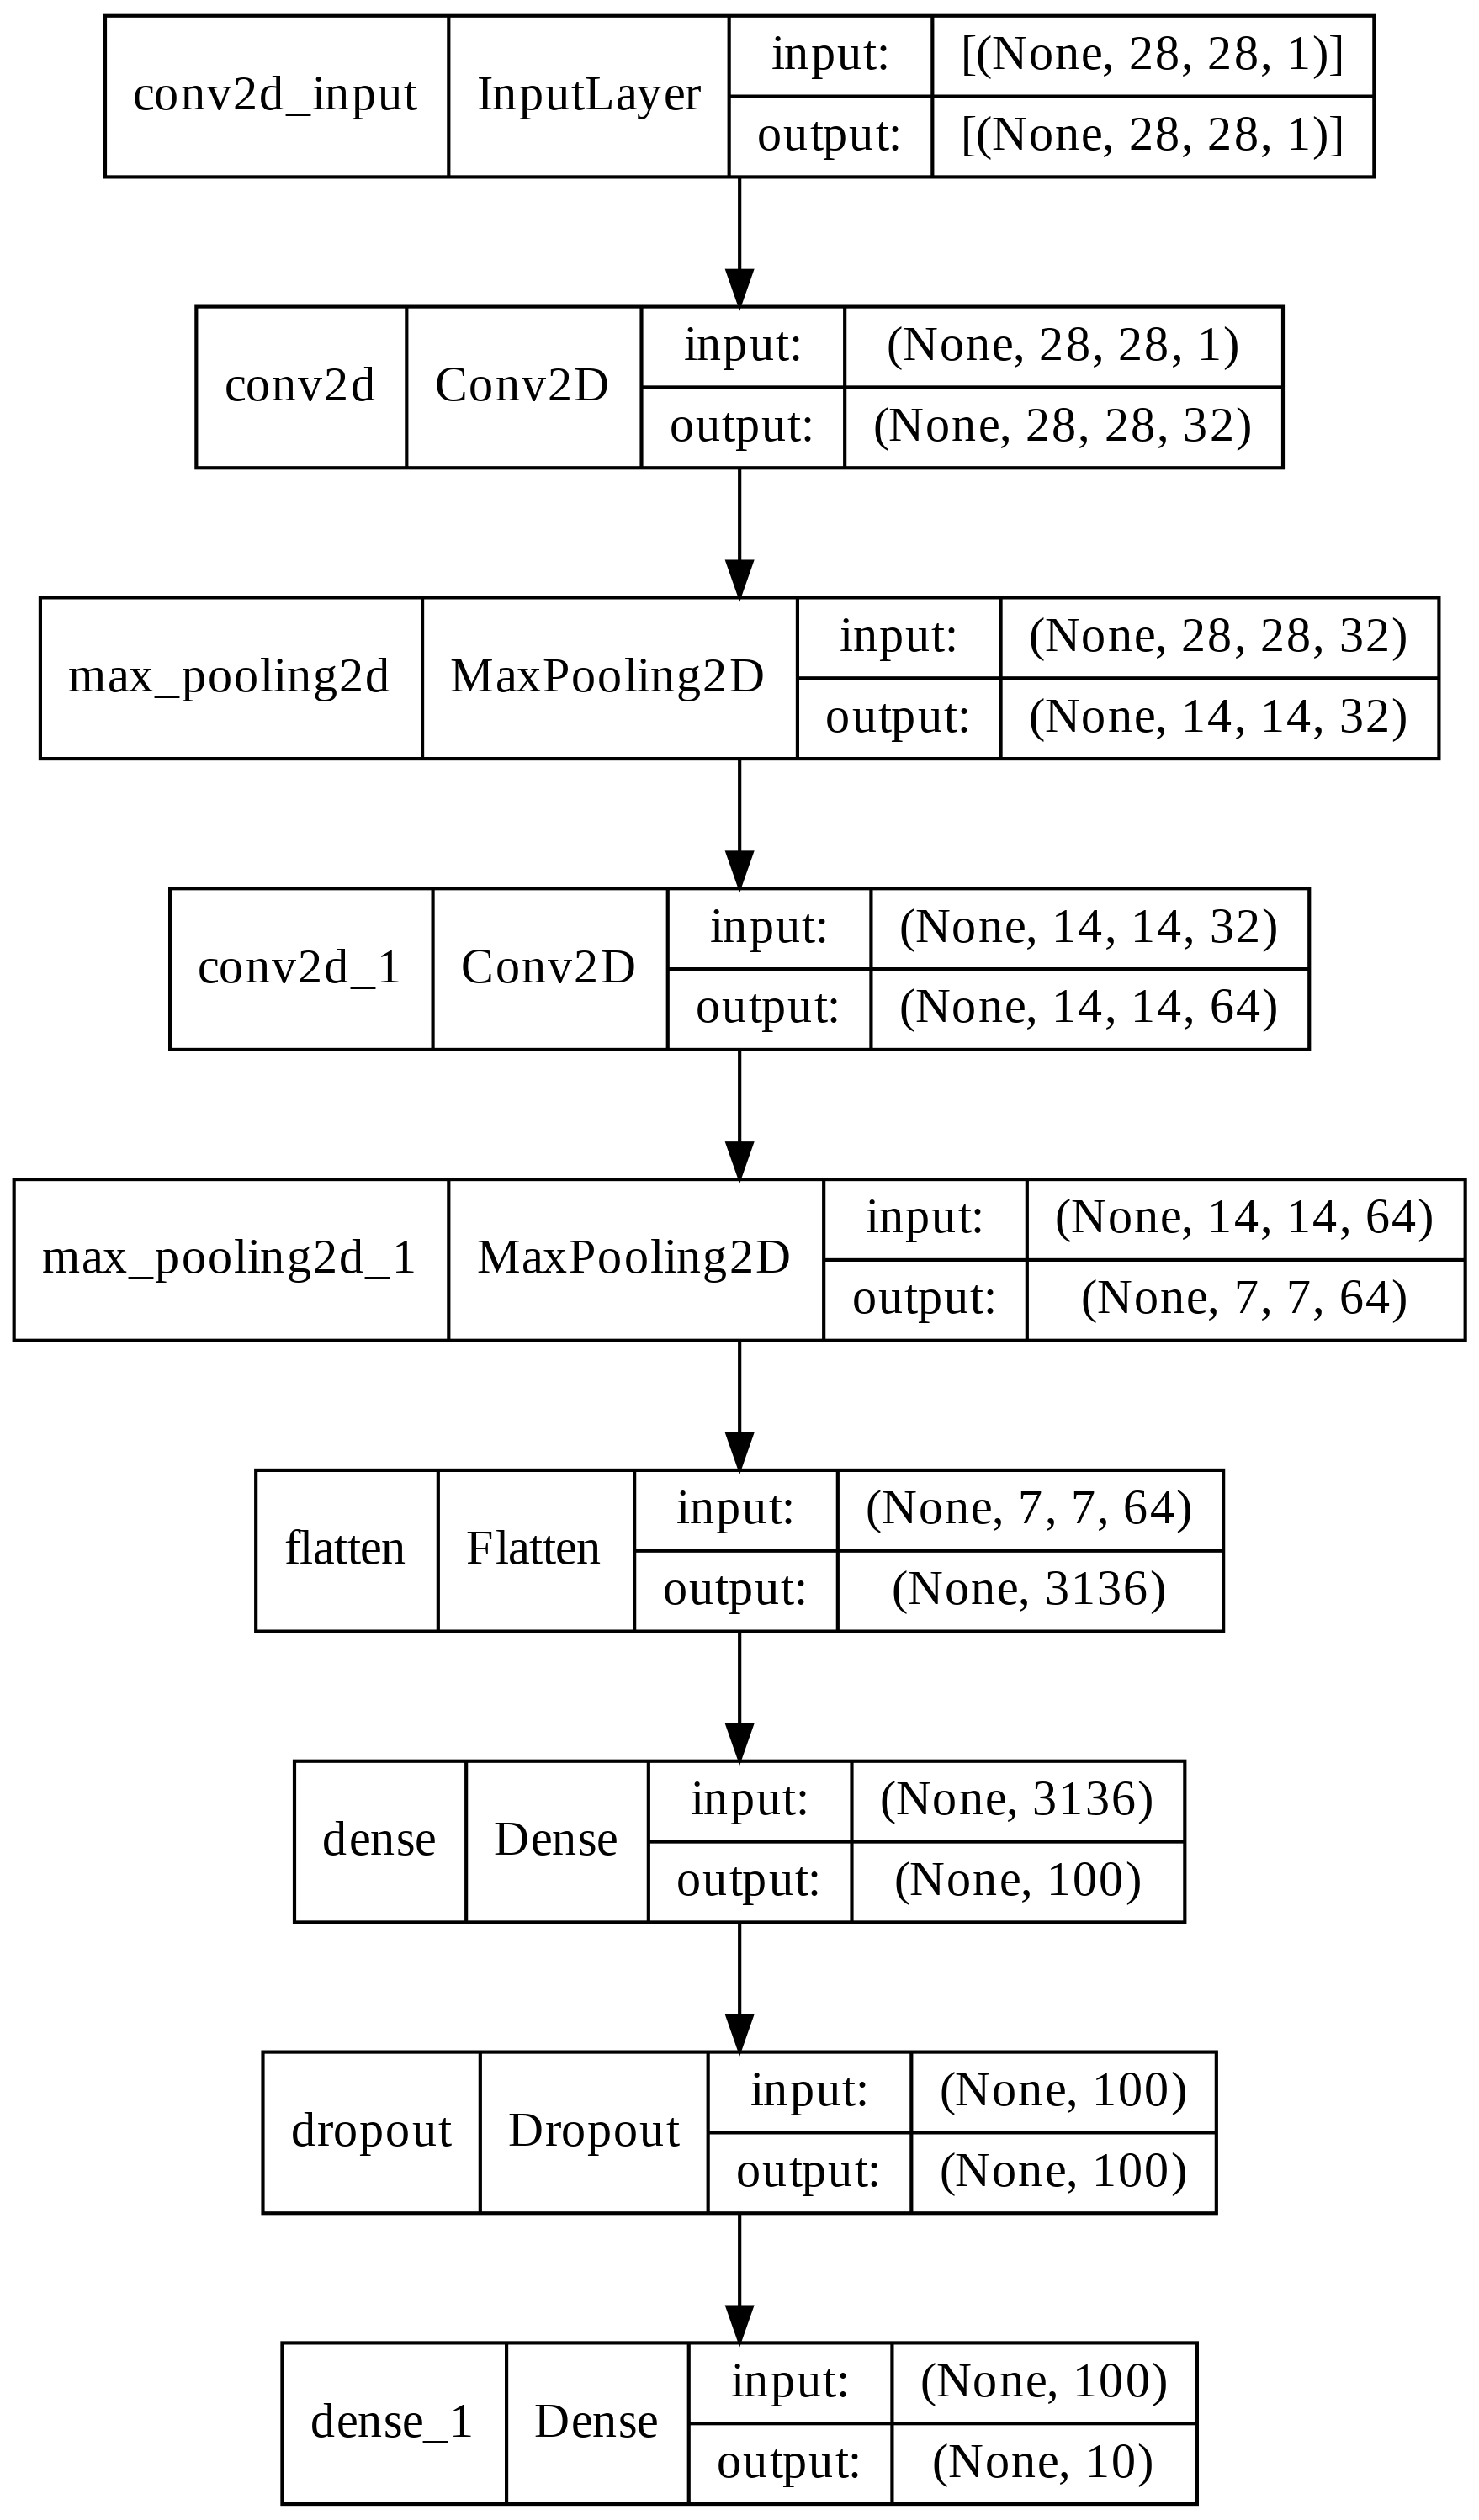

In [9]:
# show_shapes=True 는 입력과 출력 크기를 함께 표시한다.
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)

### 3. 모델 컴파일 훈련

**3.1 콜백 객체 지정**

In [10]:
# 모델 훈련 전에 옵티마이저, 손실함수, 정확도를 지정한다.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# ModelCheckpoint 콜백은 최상의 검증점수(가장 낮은 검증 손실값)를 만드는 모겔을 저장한다.
# 콜백은 훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체를 의미한다.
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')

# 조기종료를 위한 EarlyStopping 콜백 객체를 만든다.
# patience=2은 2번 연속 검증 손실값이 향상되지 않으면 훈련을 중지한다.
# restore_best_weights=True는 가장 낮은 검증 손실값을 낸 모델 파라미터로 되돌린다.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                 restore_best_weights=True)

# fit()의 callbacks 매개변수에 콜백객체들의 리스트를 전달한다.
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.5246 - accuracy: 0.8119 - val_loss: 0.3365 - val_accuracy: 0.8763
Epoch 2/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.3493 - accuracy: 0.8739 - val_loss: 0.2856 - val_accuracy: 0.8928
Epoch 3/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.2986 - accuracy: 0.8919 - val_loss: 0.2549 - val_accuracy: 0.9068
Epoch 4/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.2643 - accuracy: 0.9045 - val_loss: 0.2375 - val_accuracy: 0.9112
Epoch 5/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.2431 - accuracy: 0.9115 - val_loss: 0.2416 - val_accuracy: 0.9107
Epoch 6/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.2223 - accuracy: 0.9184 - val_loss: 0.2232 - val_accuracy: 0.9189
Epoch 7/20
1500/1500 [==============================] - 64s 43ms/step - loss: 0.2074 - accuracy: 0.9220 - val_loss: 0.2253 -

In [13]:
import matplotlib.pyplot as plt

In [10]:
# 훈련결과가 저장된 history객체의 history 딕셔너리를 이용해서
# 훈려ㄴ세트의 손실값을 그래츠로 그린다.
plt.plot(history.history['loss'])
# 검증세트의 손실값을 그래프로 그린다.
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.xlabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 4. 모델 평가와 예측
**4.1 성능 평가**

In [11]:
# 검증 세트에 대한 성능 평가를 수행한다.
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 4s 11ms/step - loss: 0.2232 - accuracy: 0.9189


[0.22323714196681976, 0.918916642665863]

**4.2 예측**

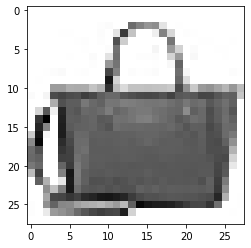

In [14]:
# 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정하자.
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [15]:
# predict() 으로 훈련한 모델을 사용하여 새로운 데이터에 대해 예측을 해본다.
preds = model.predict(val_scaled[0:1])
print(preds)

[[1.5360621e-15 1.7926249e-19 5.4186228e-16 3.0319981e-16 1.2425894e-15
  1.4388955e-16 2.0880396e-14 7.2321308e-17 1.0000000e+00 4.5265437e-18]]


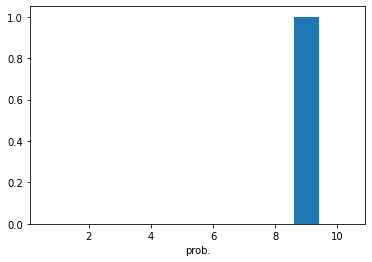

In [18]:
# 예측 결과를 그래프로 그려보면 확실히 알 수 있다.
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.xlabel('prob.')
plt.show()

In [19]:
# 패션 MNIST 데이터셋의 레이블을 리스트로 만든다.
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [21]:
import numpy as np
# argmax(preds)은 예측값이 저장된 preds에서 가장 큰 값의 인덱스를 반환한다.
# 반환된 인덱스에 해당하는 리스트의 값을 출력한다.
print(classes[np.argmax(preds)])

가방
